In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pandas.plotting import scatter_matrix
import numpy as np


In [2]:
df = pd.read_csv("../data/data_new1.csv")

In [3]:
df.shape

(61472, 4)

In [4]:
df.dropna(axis=0)
df.shape

(61472, 4)

In [5]:
df.head

<bound method NDFrame.head of         ir1  ir2  degree             time
0      15.7  2.8       3  10:49:46.354269
1      16.0  2.8       3  10:49:46.379355
2      16.0  3.1       3  10:49:46.403498
3      16.0  3.1       3  10:49:46.427674
4      16.3  3.1       3  10:49:46.452928
...     ...  ...     ...              ...
61467  66.3  3.9       3  11:27:47.631665
61468  65.4  4.0       3  11:27:47.659675
61469  65.4  4.0       3  11:27:47.686931
61470  66.2  4.0       3  11:27:47.717632
61471  66.2  4.0       3  11:27:47.748315

[61472 rows x 4 columns]>

In [ ]:
sns.pairplot(df, diag_kind='hist')

plt.show()

In [ ]:
scatter_matrix(df, alpha=0.5, figsize=(8, 8), diagonal='kde')

plt.show()

In [ ]:

sns.boxplot(x="degree", y="ir1", data=df)

plt.show()


In [ ]:
# Grouped boxplots by pandas

df.boxplot(column=["ir1"], by=["degree"])

plt.show()


In [5]:
#df.replace({'C1': 'a_old'}, {'C1': 'a_new'})
#출처: https://rfriend.tistory.com/265 [R, Python 분석과 프로그래밍의 친구 (by R Friend)]

df = df.replace({'degree':[1,2,3,4,5]}, {'degree':['leftleft','left','straight','right','rightright']})

# 0값 제거
df = df[df !=0]

# Feature 추가(ir 차 / 비율)

In [6]:
# df['ir_1-2'] = round(df['ir1'] - df['ir2'],3)
# df['ir_1/2'] = round(df['ir1'] / df['ir2'],3) # 소숫점 2자리
df['ir_1-2'] = df['ir1'] - df['ir2']
df['ir_1/2'] = df['ir1'] / df['ir2']

df = df[df !=0]
df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(axis=0)

df = df.loc[:, ['ir1', 'ir2', 'degree', 'ir_1-2', 'ir_1/2']]

In [8]:
df

,ir1,ir2,degree,ir_1-2,ir_1/2
0,15.7,2.8,3,12.9,5.607143
1,16.0,2.8,3,13.2,5.714286
2,16.0,3.1,3,12.9,5.161290
3,16.0,3.1,3,12.9,5.161290
4,16.3,3.1,3,13.2,5.258065
...,...,...,...,...,...
61467,66.3,3.9,3,62.4,17.000000
61468,65.4,4.0,3,61.4,16.350000
61469,65.4,4.0,3,61.4,16.350000
61470,66.2,4.0,3,62.2,16.550000


In [ ]:
df.isnull()

In [11]:
# normalization

from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()
scaler.fit(df)
df_n = pd.DataFrame(scaler.transform(df),columns=['ir_L', 'ir_R', 'ir_1-2', 'ir_1/2'])

ValueError: Shape of passed values is (61420, 5), indices imply (61420, 4)

In [ ]:
inputs

# Split data

In [12]:
# Original Data
df_inputs = df.loc[:,['ir1', 'ir2', 'ir_1-2', 'ir_1/2']]
df_outputs = df.loc[:,['degree']]

# Normalized Data
# df_inputs = df_n.loc[:,['ir_L', 'ir_R']]
# df_outputs = df_n.loc[:,['degree']]
# df_inputs = df_n.loc[:,['ir_L', 'ir_R', 'ir_1-2', 'ir_1/2']]
# df_outputs = df_n.loc[:,['degree']]

inputs = np.array(df_inputs)
outputs = np.array(df_outputs)

In [13]:
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()
scaler.fit(df)
df_n = pd.DataFrame(scaler.transform(df),columns=['ir_L', 'ir_R', 'ir_1-2', 'ir_1/2'])

ValueError: Shape of passed values is (61420, 5), indices imply (61420, 4)

In [14]:
num_data = len(inputs)
TRAIN_SPLIT = int(0.6 * num_data)
TEST_SPLIT = int(0.2 * num_data + TRAIN_SPLIT)

In [15]:
inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

In [16]:
print(inputs_train.shape)
print(inputs_train.ndim)
print(outputs_train.shape)

(36852, 4)
2
(36852, 1)


# Random Forest Classification

In [17]:
from sklearn.ensemble import RandomForestClassifier

In [18]:
# inputs_train[~np.isnan(inputs_train).any(axis=1)]
# outputs_train[~np.isnan(outputs_train).any(axis=1)]
rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456)
rf.fit(inputs_train, outputs_train)

/Users/peter/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=123456,
                       verbose=0, warm_start=False)

In [19]:
from sklearn.metrics import accuracy_score

predicted = rf.predict(inputs_test)
accuracy = accuracy_score(outputs_test, predicted)

print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')

Out-of-bag score estimate: 0.868
Mean accuracy score: 0.749


In [33]:
# test = 15.4, 3.0 #3
test = 2.9, 7.0 #4
# rf.predict([inputs_test[0]])
pred = rf.predict([[test[0], test[1], test[0]-test[1], test[0]/test[1]]])
pred[0]

4

In [34]:
from sklearn.externals import joblib 
# 객체를 pickled binary file 형태로 저장한다 
file_name = '../model/rf.pkl' 
joblib.dump(rf, file_name)

/Users/peter/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['../model/rf.pkl']

In [35]:
from sklearn.externals import joblib 
# pickled binary file 형태로 저장된 객체를 로딩한다 
file_name = '../model/rf.pkl' 
model = joblib.load(file_name) 

# test = 15.4, 3.0 #3
test = 2.9, 7.0 #4
# rf.predict([inputs_test[0]])
pred = model.predict([[test[0], test[1], test[0]-test[1], test[0]/test[1]]])
pred[0]

4

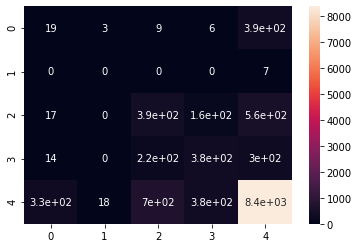

In [17]:
from sklearn.metrics import confusion_matrix

cm = pd.DataFrame(confusion_matrix(outputs_test, predicted))
#cm = pd.DataFrame(confusion_matrix(outputs_test, predicted), columns=df.degree, index=df.degree)

sns.heatmap(cm, annot=True)

# DNN

In [ ]:
import tensorflow as tf

In [ ]:
inputs = []
outputs = []

DIRECTIONS = [
    'leftleft',
    'left',
    'straight',
    'right',
    'rightright'
]

NUM_DIRECTIONS = len(DIRECTIONS)
ONE_HOT_ENCODED_DIRECTIONS = np.eye(NUM_DIRECTIONS)

NUM_DATAS = len(df)

for i in range(NUM_DATAS):
    tensor = []
    tensor += [
        (df['ir1'][i]), (df['ir2'][i]), (df['ir_1-2'][i]), 
        (df['ir_1/2'][i])
    ]
#     tensor += [
#         (df['ir1'][i]), (df['ir2'][i])
#     ]
    output = ONE_HOT_ENCODED_DIRECTIONS[DIRECTIONS.index(df['degree'][i])]
    
    inputs.append(tensor)
    outputs.append(output)
    
# from sklearn.preprocessing import MaxAbsScaler
# scaler = MaxAbsScaler()
# scaler.fit(inputs)
# inputs = scaler.transform(inputs)

inputs = np.array(inputs)
outputs = np.array(outputs)

In [ ]:
# for randomize
tf.random.set_seed(1337)

num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)


inputs = inputs[randomize]
outputs = outputs[randomize]

In [ ]:

model = tf.keras.Sequential()
# model.add(tf.keras.Input(shape = inputs_train.shape[1]))
# model.add(tf.keras.layers.SimpleRNN(100, return_sequences = False, input_shape = (inputs_train.shape[1], ) ))
model.add(tf.keras.layers.SimpleRNN(100, input_shape = (1,4), return_sequences = False))
# model.add(tf.keras.layers.LSTM(50, input_shape=(1,4), return_sequences = True)) # (timestep, feature)
# model.add(tf.keras.layers.LSTM(20, return_sequences = False)) # (timestep, feature) 
# model.add(tf.keras.layers.Dense(10, activation='relu'))
# model.add(tf.keras.layers.Dropout(rate=.5))
# model.add(tf.keras.layers.Dense(100, activation='relu'))
# model.add(tf.keras.layers.Dropout(rate=.5))
# model.add(tf.keras.layers.Dense(10, activation='relu'))
# model.add(tf.keras.layers.Dropout(rate=.1))
# model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(5, activation='softmax')) # softmax, sigmoid

# model.compile(optimizer='adam', loss='mae', metrics=['mae']) # mse / mae / acc
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=[tf.keras.metrics.CategoricalAccuracy()])

model.summary()

In [ ]:
# inputs_train = np.reshape(inputs_train, (inputs_train.shape[0], 1, inputs_train.shape[1]))
# outputs_train = np.reshape(outputs_train, (outputs_train.shape[0], 1, outputs_train.shape[1]))
# inputs_train = np.reshape(inputs_train, (1, inputs_train.shape[0], inputs_train.shape[1]))
# outputs_train = np.reshape(outputs_train, (1, outputs_train.shape[0], outputs_train[1]))

# history = model.fit(inputs_train, outputs_train, epochs=1, batch_size=1, validation_data=(inputs_validate, outputs_validate))
history = model.fit(inputs_train, outputs_train, epochs=10, batch_size=1)

# history = model.fit(inputs_train, outputs_train, epochs=10, batch_size=1)


In [ ]:
outputs_predict = model.predict(inputs_test)

In [ ]:
print(outputs_predict[1][1])

In [ ]:
plt.scatter(outputs_test, outputs_predict, alpha=0.4)
plt.xlabel("Actual degree")
plt.ylabel("Predicted degree")
plt.title("DNN(Regression)")
plt.show()

# Feature 추가(mot_L, mot_R)

In [ ]:
def chdeg(degree_original):
    degree = ((degree_original - 50)*1.5)//1
    if degree <= 0:
        left = 25
        right = 25 + abs(degree)
    else:
        left = 25 - abs(degree)
        right = 25
    return left, right

left = []
right = []
for i in range(len(df)):
    left.append(chdeg(df['degree'][i])[0])
    right.append(chdeg(df['degree'][i])[1])
    
df['mot_L'] = left
df['mot_R'] = right

In [ ]:
sns.pairplot(df, diag_kind='hist')

plt.show()

In [ ]:
scatter_matrix(df, alpha=0.5, figsize=(8, 8), diagonal='kde')

plt.show()

# Feature 추가(ir distance 차이, 비율)

### ir 좌우 차이

In [ ]:
df['ir_R-L'] = df['ir_R'] - df['ir_L']
df['ir_L/R'] = df['ir_L'] / df['ir_R'] 
df

In [ ]:
sns.pairplot(df, diag_kind='hist')

plt.show()

In [ ]:
scatter_matrix(df, alpha=0.5, figsize=(8, 8), diagonal='kde')

plt.show()

# Except degree under 10 over 90 data

In [ ]:
df.sort_values(by=['degree'])

In [ ]:
df_s = df.loc[(10 < df['degree']) & (df['degree'] < 90), : ]

In [ ]:
sns.pairplot(df_s, diag_kind='hist')

plt.show()

In [ ]:
scatter_matrix(df_s, alpha=0.5, figsize=(8, 8), diagonal='kde')

plt.show()

# exclude degree over 50

In [ ]:
df_d = df.loc[df['degree'] < 50, : ]
df_d

In [ ]:
sns.pairplot(df_d, diag_kind='hist')

plt.show()

In [ ]:
scatter_matrix(df_d, alpha=0.5, figsize=(8, 8), diagonal='kde')

plt.show()

# Time stamp 설정

In [ ]:
# Time Stamp를 지정하여 그 안의 값들에 대해 대표값으로 데이터를 구성
# 대표값은 평균(averave), 중앙값(median), 최빈값(mode) 중 평균값과 중앙값을 우선적으로 테스트한다.

In [ ]:
df

In [ ]:
frame = 5
length = len(df)
df_frame = pd.DataFrame(columns=['ir_L', 'ir_R', 'degree', 'mot_L', 'mot_R', 'ir_R-L', 'ir_L/R'])
ir_L, ir_R, degree, mot_L, mot_R, ir_RL, ir_LR = [], [], [], [], [], [], []

for i in range(length//frame):
    a = i*frame
    b = (i+1)*frame
    ir_L.append(np.median(df['ir_L'][a:b]))
    ir_R.append(np.median(df['ir_R'][a:b]))
    degree.append(np.median(df['degree'][a:b]))
    mot_L.append(np.median(df['mot_L'][a:b]))
    mot_R.append(np.median(df['mot_R'][a:b]))
    ir_RL.append(np.median(df['ir_R-L'][a:b]))
    ir_LR.append(np.median(df['ir_L/R'][a:b]))
df_frame['ir_L'] = ir_L
df_frame['ir_R'] = ir_R
df_frame['degree'] = degree
df_frame['mot_L'] = mot_L
df_frame['mot_R'] = mot_R
df_frame['ir_R-L'] = ir_RL
df_frame['ir_L/R'] = ir_LR

In [ ]:
df_frame

In [ ]:
sns.pairplot(df_frame, diag_kind='hist')

plt.show()

In [ ]:
scatter_matrix(df_frame, alpha=0.5, figsize=(8, 8), diagonal='kde')

plt.show()

In [ ]:
import tensorflow as tf

# Original Data
df_inputs = df_frame.loc[:,['ir_L', 'ir_R', 'ir_R-L', 'ir_L/R']]
df_outputs = df_frame.loc[:,['degree']]

# Normalized Data
# df_inputs = df_n.loc[:,['ir_L', 'ir_R']]
# df_outputs = df_n.loc[:,['degree']]

inputs = np.array(df_inputs)
outputs = np.array(df_outputs)

num_data = len(inputs)
TRAIN_SPLIT = int(0.6 * num_data)
TEST_SPLIT = int(0.2 * num_data + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])



model = tf.keras.Sequential()
model.add(tf.keras.Input(shape = inputs_train.shape[1]))
model.add(tf.keras.layers.Dense(50, activation='relu'))
# model.add(tf.keras.layers.Dropout(rate=.2))
# model.add(tf.keras.layers.Dense(10, activation='relu'))
# model.add(tf.keras.layers.Dropout(rate=.2))

model.add(tf.keras.layers.Dense(1, activation='relu'))



# model.compile(optimizer='adam', loss='mae', metrics=['mae']) # mse / mae
model.compile(optimizer='adam', loss='mse', metrics=['mse']) # mse / mae
model.summary()

In [ ]:
history = model.fit(inputs_train, outputs_train, epochs=1, batch_size=1, validation_data=(inputs_validate, outputs_validate))

In [ ]:
outputs_predict = model.predict(inputs_test)

In [ ]:
plt.scatter(outputs_test, outputs_predict, alpha=0.4)
plt.xlabel("Actual degree")
plt.ylabel("Predicted degree")
plt.title("DNN(Regression)")
plt.show()

In [ ]:
ir_L = 18.8
ir_R = 2.7
ir_RL = ir_R - ir_L
ir_LR = ir_L / ir_R
data = [ir_L, ir_R, ir_RL, ir_LR]
data

In [ ]:
model.predict([[data]])[0][0]

In [ ]:
from train import Model

In [ ]:
m = Model("../data/data.csv")
m.feature_engineering()
m.set_data()
m.train()

In [ ]:
plt.scatter(m.outputs_test, m.outputs_predict, alpha=0.4)
plt.xlabel("Actual degree")
plt.ylabel("Predicted degree")
plt.title("DNN(Regression)")
plt.show()

In [ ]:
m.collect_data()

In [ ]:
from modicar import Car
import modi

In [ ]:
bundle = modi.MODI()
car = Car()

mot = bundle.motors[0]
ir1 = bundle.irs[0]
ir2 = bundle.irs[1]
btn = bundle.buttons[0]
dial = bundle.dials[0]

In [ ]:
car.learn()

In [ ]:
car.collect_data(mot, ir1, ir2, btn, dial)

In [ ]:
car.start(mot, ir1, ir2)

# Sparse_categorical_crossentropy

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import numpy as np

df = pd.read_csv("../data/data_new1.csv")





#df.replace({'C1': 'a_old'}, {'C1': 'a_new'})
#출처: https://rfriend.tistory.com/265 [R, Python 분석과 프로그래밍의 친구 (by R Friend)]

# df = df.replace({'degree':[1,2,3,4,5]}, {'degree':['leftleft','left','straight','right','rightright']})

# 0값 제거
df = df[df !=0]

#feature 추가
df['ir_1-2'] = round(df['ir1'] - df['ir2'],3)
df['ir_1/2'] = round(df['ir1'] / df['ir2'],3) # 소숫점 2자리

inputs = []
outputs = []


# Original Data
# df_inputs = df.loc[:,['ir1', 'ir2', 'ir_1-2', 'ir_1/2']]
# df_outputs = df.loc[:,['degree']]
df_inputs = df.loc[:,['ir_1-2', 'ir_1/2']]
df_outputs = df.loc[:,['degree']]

# Normalized Data
# df_inputs = df_n.loc[:,['ir_L', 'ir_R']]
# df_outputs = df_n.loc[:,['degree']]

inputs = np.array(df_inputs)
outputs = np.array(df_outputs)

    
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()
scaler.fit(inputs)
inputs = scaler.transform(inputs)
print(inputs)
print(outputs)

In [ ]:
# for randomize
tf.random.set_seed(1337)

num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)


inputs = inputs[randomize]
outputs = outputs[randomize]

In [ ]:
num_data = len(inputs)
TRAIN_SPLIT = int(0.6 * num_data)
TEST_SPLIT = int(0.2 * num_data + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print(inputs_train.shape)
print(inputs_train.ndim)

In [ ]:
import tensorflow as tf

model = tf.keras.Sequential()
model.add(tf.keras.Input(shape = inputs_train.shape[1]))
# model.add(tf.keras.layers.SimpleRNN(100, return_sequences = False, input_shape = (inputs_train.shape[1], ) ))
# model.add(tf.keras.layers.SimpleRNN(100, input_shape = (1,4), return_sequences = False))
# model.add(tf.keras.layers.LSTM(20, input_shape=(1,4))) # (timestep, feature) 
# model.add(tf.keras.layers.Dense(10, activation='relu'))
# model.add(tf.keras.layers.Dropout(rate=.5))
model.add(tf.keras.layers.Dense(10, activation='relu'))
# model.add(tf.keras.layers.Dropout(rate=.5))
# model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=.1))
# model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(6, activation='softmax')) # softmax, sigmoid

# model.compile(optimizer='adam', loss='mae', metrics=['mae']) # mse / mae / acc
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=[tf.keras.metrics.CategoricalAccuracy()])

model.summary()

In [ ]:
# inputs_train = np.reshape(inputs_train, (inputs_train.shape[0], 1, inputs_train.shape[1]))
# outputs_train = np.reshape(outputs_train, (outputs_train.shape[0], 1, outputs_train.shape[1]))

# history = model.fit(inputs_train, outputs_train, epochs=1, batch_size=1, validation_data=(inputs_validate, outputs_validate))
history = model.fit(inputs_train, outputs_train, epochs=10, batch_size=10)

# history = model.fit(inputs_train, outputs_train, epochs=10, batch_size=1)
